In [ ]:
# This tutorial was developed for SENSE training by Johannes Hansen and delivered by Victor Elvira, and made available online at https://github.com/jnhansen/sense_week2
# This work is licensed under a Creative Commons Attribution 4.0 International License: https://creativecommons.org/licenses/by/4.0/ 


In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# 1.1 Linear Regression

## Introduction

In this practical, 
we will try to predict Above-Ground Biomass (AGB)
from Sentinel-1 radar data
(whether that is a sensible thing to do is another question...).

The provided data is for a part of Scotland (around Galloway Forest Park),
including two overlapping Sentinel-1 images
and an AGB map for the year 2017.

We will be using the `xarray` library for working with NetCDF files.

## Sentinel-1 images

Two Sentinel-1 images of our study area are provided,
one in ascending orbit and one in descending orbit.
The data has been pre-processed and resampled to 50m resolution.

The two images have the following identifiers:
- `S1A_IW_GRDH_1SDV_20170406T175832_20170406T175857_016027_01A718_FC6C` (ascending orbit)
- `S1A_IW_GRDH_1SDV_20170408T063006_20170408T063031_016049_01A7CF_B212` (descending orbit)

Let's now read the data set and investigate its contents.

In [2]:
s1 = xr.open_dataset('data/s1_50m.nc')

C:\Users\s2112771\Anaconda3\envs\SENSE_training\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'rasterio' loading failed:
DLL load failed while importing crs: The specified module could not be found.
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [3]:
s1

<xarray.Dataset>
Dimensions:         (y: 2081, x: 2281)
Coordinates:
    lat             (y, x) float64 ...
    lon             (y, x) float64 ...
  * x               (x) float64 1.849e+05 1.849e+05 ... 2.988e+05 2.989e+05
  * y               (y) float64 6.268e+05 6.268e+05 ... 5.229e+05 5.228e+05
Data variables:
    Sigma0_VH_asc   (y, x) float32 ...
    Sigma0_VH_desc  (y, x) float32 ...
    Sigma0_VV_asc   (y, x) float32 ...
    Sigma0_VV_desc  (y, x) float32 ...
Attributes: (12/33)
    ncols:                     8106
    nrows:                     7393
    nbands:                    2
    time_start:                06-APR-2017 17:58:42.341317
    orbit_direction:           ASCENDING
    mode:                      IW
    ...                        ...
    description:               Sentinel-1 IW Level-1 GRD Product - Unit: inte...
    file_type:                 ENVI Standard
    header_offset:             0
    interleave:                bsq
    lines:                     2081
    samples:                   2281

We can visualise the data set by plotting each variable individually:

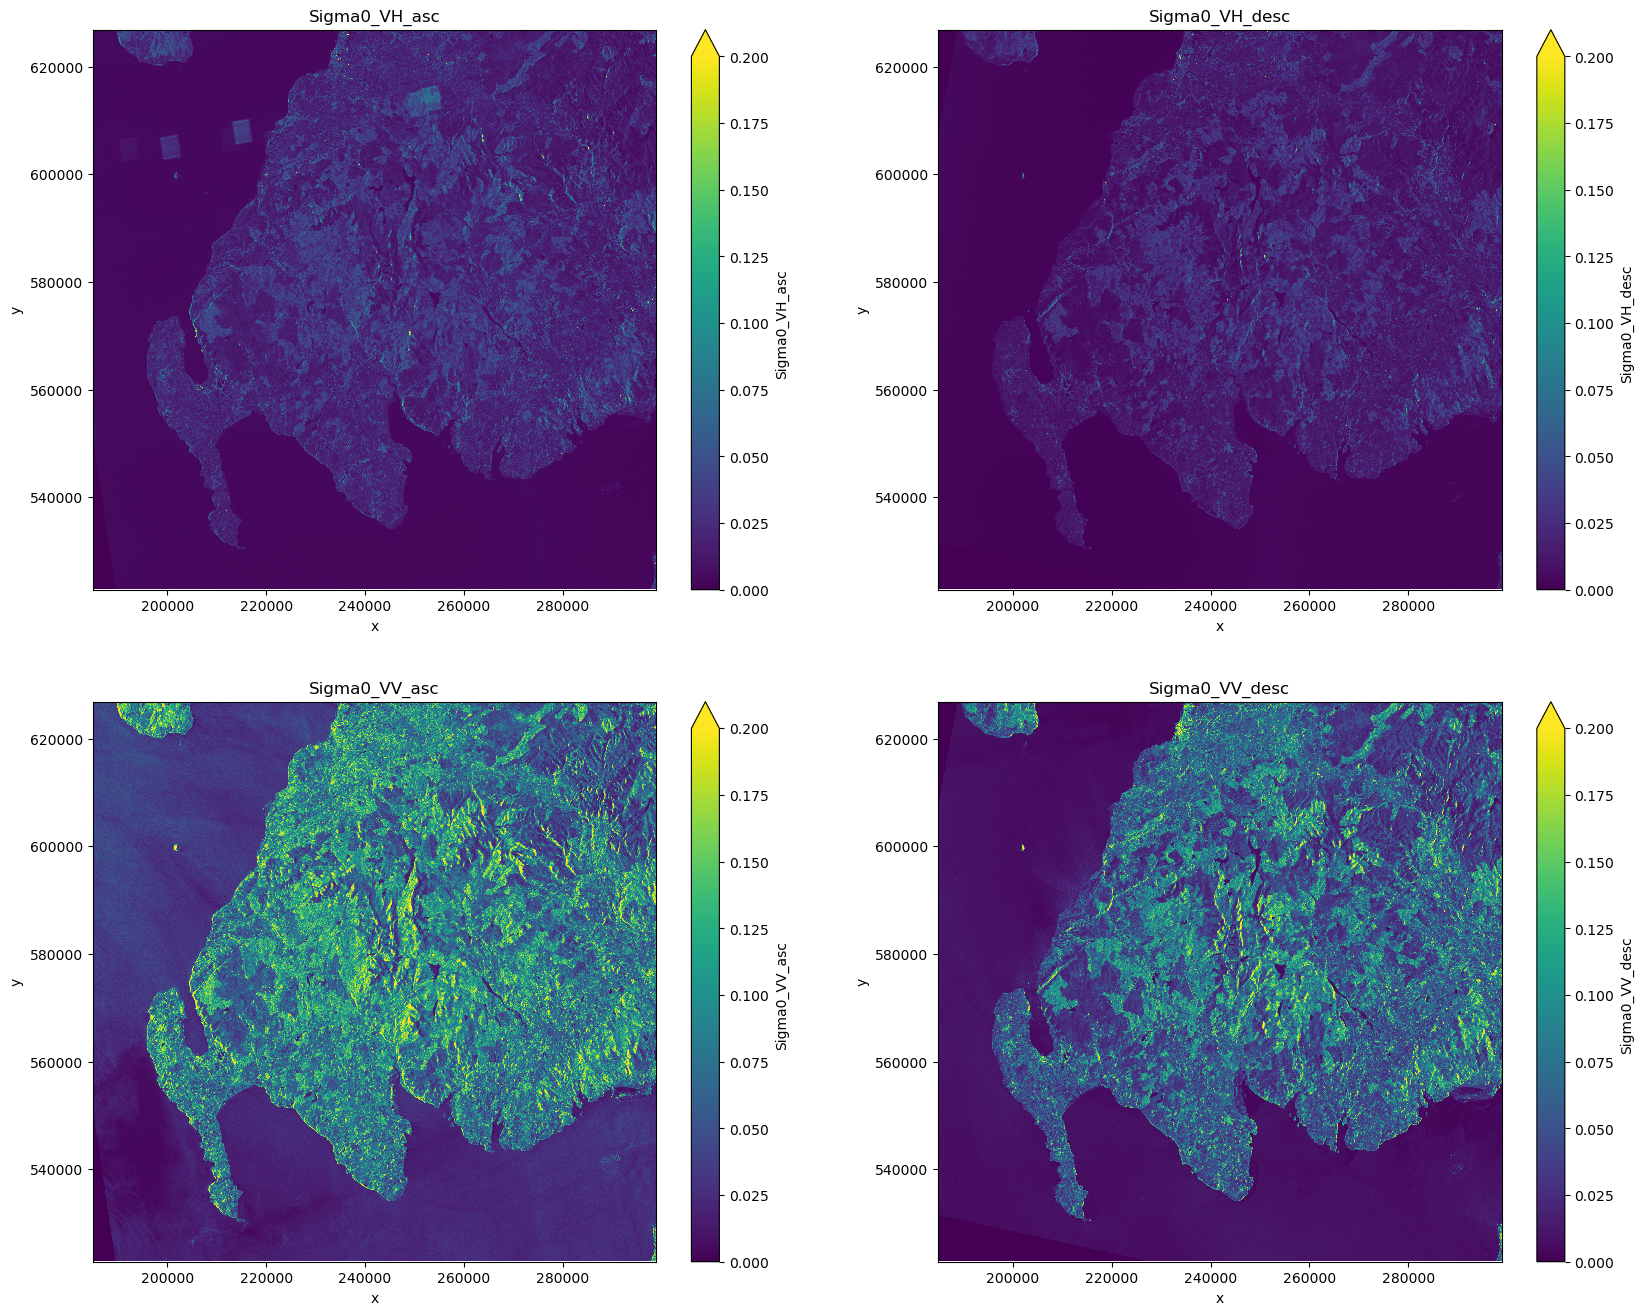

In [4]:
# Create 2x2 subplot grid
fig, ax = plt.subplots(2, 2, figsize=(20, 16))

# Plot each variable in individual subplot
for a, v in zip(ax.flatten(), s1.data_vars): # s1.data_vars accesses all the data variables in s1 
#     (Sigma0_VH_asc,Sigma0_VH_desc, Sigma0_VV_asc, Sigma0_VV_desc)
    s1[v].plot(ax=a, vmax=0.2)
    a.set_title(v)

## Above-Ground Biomass (AGB) map

The provided reference map is the biomass estimate by the ESA Climate Change Initiative (CCI):\
https://catalogue.ceda.ac.uk/uuid/bedc59f37c9545c981a839eb552e4084

The data set has already been reprojected and resampled to the same coordinate reference system, extent, and resolution as the Sentinel-1 data.

In [5]:
agb = xr.open_dataset('data/agb_50m.nc')

In [6]:
agb

<xarray.Dataset>
Dimensions:  (y: 2081, x: 2281)
Coordinates:
    lat      (y, x) float64 ...
    lon      (y, x) float64 ...
  * x        (x) float64 1.849e+05 1.849e+05 1.85e+05 ... 2.988e+05 2.989e+05
  * y        (y) float64 6.268e+05 6.268e+05 6.267e+05 ... 5.229e+05 5.228e+05
Data variables:
    agb      (y, x) float32 ...
    agb_se   (y, x) float32 ...
    crs      |S1 ...
Attributes: (12/48)
    title:                      ESA CCI above-ground biomass product level 4,...
    institution:                GAMMA Remote Sensing
    source:                     ALOS-2 PALSAR-2 FB and WB mosaics, Sentinel-1...
    history:                    GSV estimation with BIOMASAR-L, v201906, GSV ...
    references:                 http://cci.esa.int/biomass
    tracking_id:                4e618436-c170-3165-8781-046b3aff5bf3
    ...                         ...
    id:                         ESACCI-BIOMASS-L4-AGB-MERGED-100m-2017-fv1.0.nc
    transform:                  [ 5.00000000e+01  0.00000000e+00  1.84880892e...
    crs:                        EPSG:27700
    coordinate_system_string:   PROJCS["OSGB 1936 / British National Grid",GE...
    lines:                      2081
    samples:                    2281

The AGB map comes with its own error estimates. We can visualise the AGB map and its error estimates:

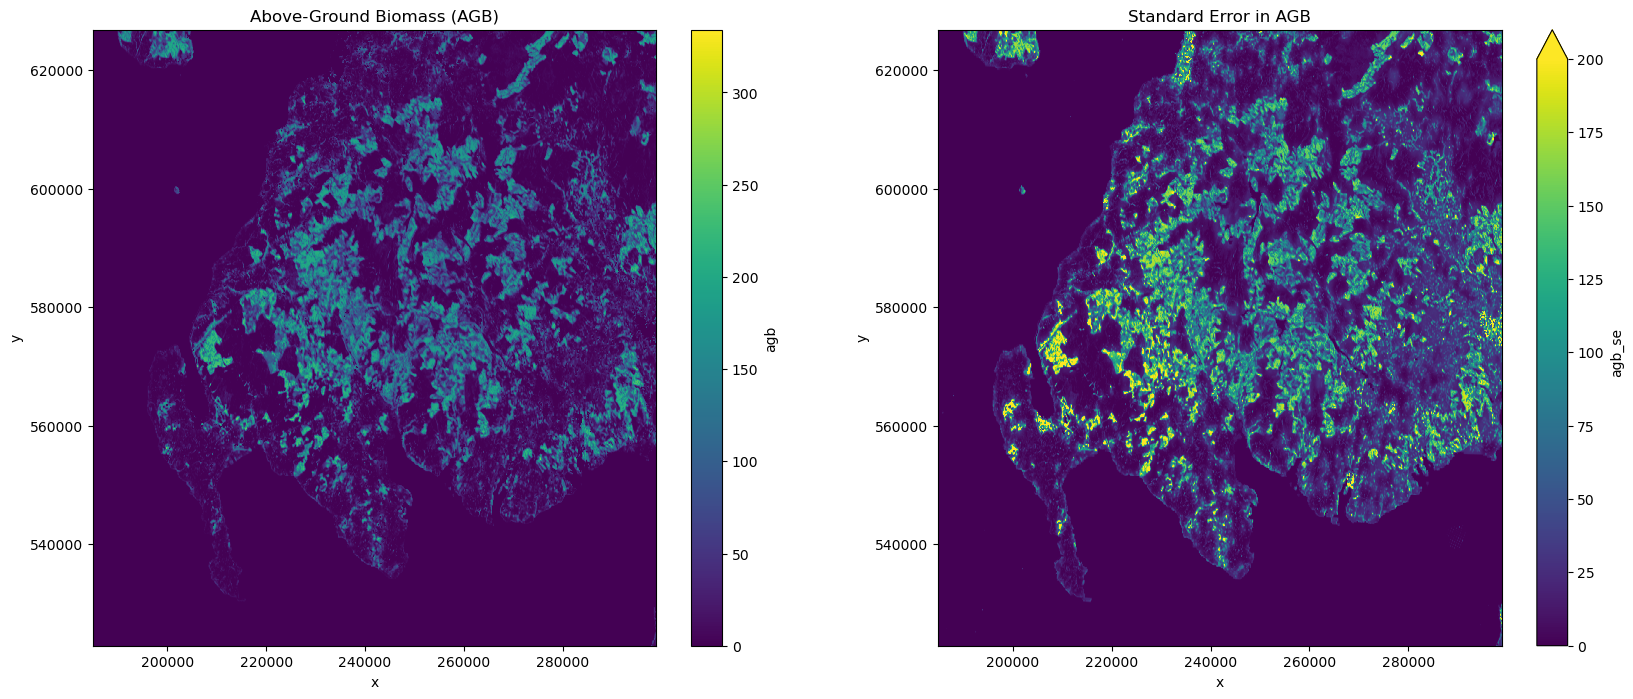

In [7]:
# Create 1x2 subplot grid
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
agb['agb'].plot(ax=ax[0])
ax[0].set_title('Above-Ground Biomass (AGB)')
agb['agb_se'].plot(vmax=200, ax=ax[1])
ax[1].set_title('Standard Error in AGB');

---

# Linear Regression

Now that we have loaded our data sets we can perform a simple linear regression to predict the AGB 
given the Sentinel-1 data.

## Prepare data

We need to get the image data into the form $(N, D)$ where $N$ is the number of data points and $D = 4$ the dimension (number of features).

We can do this by converting the variables of the data set into a new dimension using `.to_array()`,
and combining the `'x'` and `'y'` dimensions into a new dimension `'z'` using `.stack()`.

In [8]:
X_flat = s1.to_array(dim='variable').stack(z=('x', 'y')).transpose('z', 'variable')

In our $2281 \times 2081$ image we have $4\,746\,761$ pixels, i.e. data points:

In [9]:
X_flat.shape

(4746761, 4)

In [10]:
y_flat = agb['agb'].stack(z=('x', 'y'))

In [11]:
y_flat.shape

(4746761,)

Create a mask for NaN values:

In [13]:
mask = ~np.isnan(X_flat.values).any(axis=1)
mask

array([ True,  True,  True, ...,  True,  True, False])

---

# Compute weights manually

The ordinary least squares estimator for the linear regression is given by

$$\mathbf{\hat\beta} = \left(\mathbf{X}^T \mathbf{X}\right)^{-1} \mathbf{X}^T \mathbf{y}$$

Let's now construct $\mathbf{X}$ and $\mathbf{y}$. \
We need to remove any NaN values by applying our mask and also add a column of ones to $\mathbf{X}$ (this is to fit the intercept).

In [14]:
# Create new matrix X that contains the intercept
X = X_flat.values[mask]
# Insert a column of ones
X = np.insert(X, 0, 1, axis=1)

In [15]:
X

array([[1.        , 0.00489198, 0.        , 0.0521906 , 0.        ],
       [1.        , 0.00478598, 0.        , 0.03505806, 0.        ],
       [1.        , 0.00537562, 0.        , 0.04262001, 0.        ],
       ...,
       [1.        , 0.02656809, 0.02407187, 0.15513517, 0.11710459],
       [1.        , 0.02491499, 0.01958889, 0.17138469, 0.1110025 ],
       [1.        , 0.02253338, 0.01866663, 0.13009715, 0.12554842]],
      dtype=float32)

In [18]:
y = y_flat.values[mask]

Computing the regression weights $\mathbf{\hat\beta}$ is now simply a matter of applying the equation above.

In [19]:
beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

# linalg takes a matrix and inverts it.

Let's look at the computed weights:

In [21]:
# dict1 = {'intercept':sd;fjanwef[oawierhf]}

dict(zip(['intercept'] + list(X_flat['variable'].values), beta))

{'intercept': -14.197271,
 'Sigma0_VH_asc': 1043.2332,
 'Sigma0_VH_desc': 1061.25,
 'Sigma0_VV_asc': 32.7783,
 'Sigma0_VV_desc': 180.12863}

For any pixel, the predicted AGB value is

$$\hat{y}_i = \mathbf{\hat\beta} \cdot \mathbf{x}_i$$

with $$\mathbf{x}_i = \begin{pmatrix} 
1 \\
\sigma^0_\text{VH, asc} \\
\sigma^0_\text{VH, desc} \\
\sigma^0_\text{VV, asc} \\
\sigma^0_\text{VV, desc}
\end{pmatrix}$$

In [24]:
y_pred = X.dot(beta)
y_pred.shape()

TypeError: 'tuple' object is not callable

To assess quantitatively how well our linear regression fits the data,
we can compute the root mean squared error (RMSE):

$$\text{RMSE} = \sqrt{ \frac{1}{N} \sum_i^N \left( \hat{y}_i - y_i \right)^2}$$

In [23]:
rmse = np.sqrt(((y_pred - y)**2).mean())
rmse

# rrmse would be a relative root mean squared error which can be more of a useful indicator of the error on the data.

31.25592

Alternatively, we can compute the $R^2$ statistic which is defined as follows:

$$R^2 = 1 - \frac{\sum_i \left( \hat{y}_i - y_i \right)^2}{\sum_i \left( \bar{y} - y_i \right)^2}$$

In [25]:
r2 = 1 - ((y_pred - y)**2).sum() / ((y - y.mean())**2).sum()
r2

0.5254111886024475

If you are familiar with $R^2$ values, you will recognise that this is a rather terrible fit.

---

# Linear Regression using `scikit-learn`

Instead of implementing the linear regression ourselves,
we can use the extremely popular library `scikit-learn`.

While linear regression is fairly easy to implement manually, 
other regression algorithms (as well as classification and clustering algorithms)
are much more involved.

Because `scikit-learn` has a very consistent interface,
once you know how to use one estimator
all other estimators will be very easy to use.

In [29]:
from sklearn.linear_model import LinearRegression

For any `scikit-learn` estimator
(this broadly includes any regression, classification or clustering algorithm),
we first need to initialise the regression object:

In [30]:
clf = LinearRegression(fit_intercept=False)

We set `fit_intercept` to `False` because we have already introduced a column of ones into the matrix $\mathbf{X}$ for this purpose. By default, `scikit-learn` will do this for us.

More advanced algorithms will accept multiple parameters in this step,
refer to the documentation of `scikit-learn` for details.

You can find a list of all estimators here: https://scikit-learn.org/stable/modules/classes.html

## Prepare the data for working with `scikit-learn`

In the real world,
we would normally split the data into training and testing data sets.

The classifier would then be fit to (trained on) the training data and scored/validated on the testing data. This is done to avoid overfitting and give a more realistic assessment of the model performance.

In our case overfitting is unlikely since the number of samples is much larger than the number of model parameters ($N \gg D$). Furthermore, a linear regression is unlikely to adequately model this problem in the first place.

In [31]:
clf.fit(X, y)

LinearRegression(fit_intercept=False)

Extract the weights:

In [32]:
dict(zip(['intercept'] + list(X_flat['variable'].values), clf.coef_))

{'intercept': -14.197109,
 'Sigma0_VH_asc': 1043.2473,
 'Sigma0_VH_desc': 1061.2299,
 'Sigma0_VV_asc': 32.77181,
 'Sigma0_VV_desc': 180.14397}

When we compare the weights to our manually computed $\hat\beta$ above, 
we can see that they are identical except for a small numeric discrepancy.
This discrepancy can likely be attributed to internal approximations
in the `scikit-learn` implementation,
as the library is highly optimised for computational performance.

For example, the `scikit-learn` implementation is unlikely to compute 
the inverse matrix as this is a computationally expensive operation.
Instead, iterative solvers would normally be used.

Predict the AGB using our model:

In [33]:
# Create an empty xarray dataset
# that we can populate with our predictions
pred = y_flat.copy(data=np.zeros_like(y_flat.values))

# Fill in the values corresponding to our mask
pred[mask] = clf.predict(X)

Compute the $R^2$ score:

In [34]:
clf.score(X, y)

0.5254108944331954

Recreate the two-dimensional image:

In [35]:
pred = pred.unstack().transpose('y', 'x')

### Plot the reference AGB vs the predicted AGB

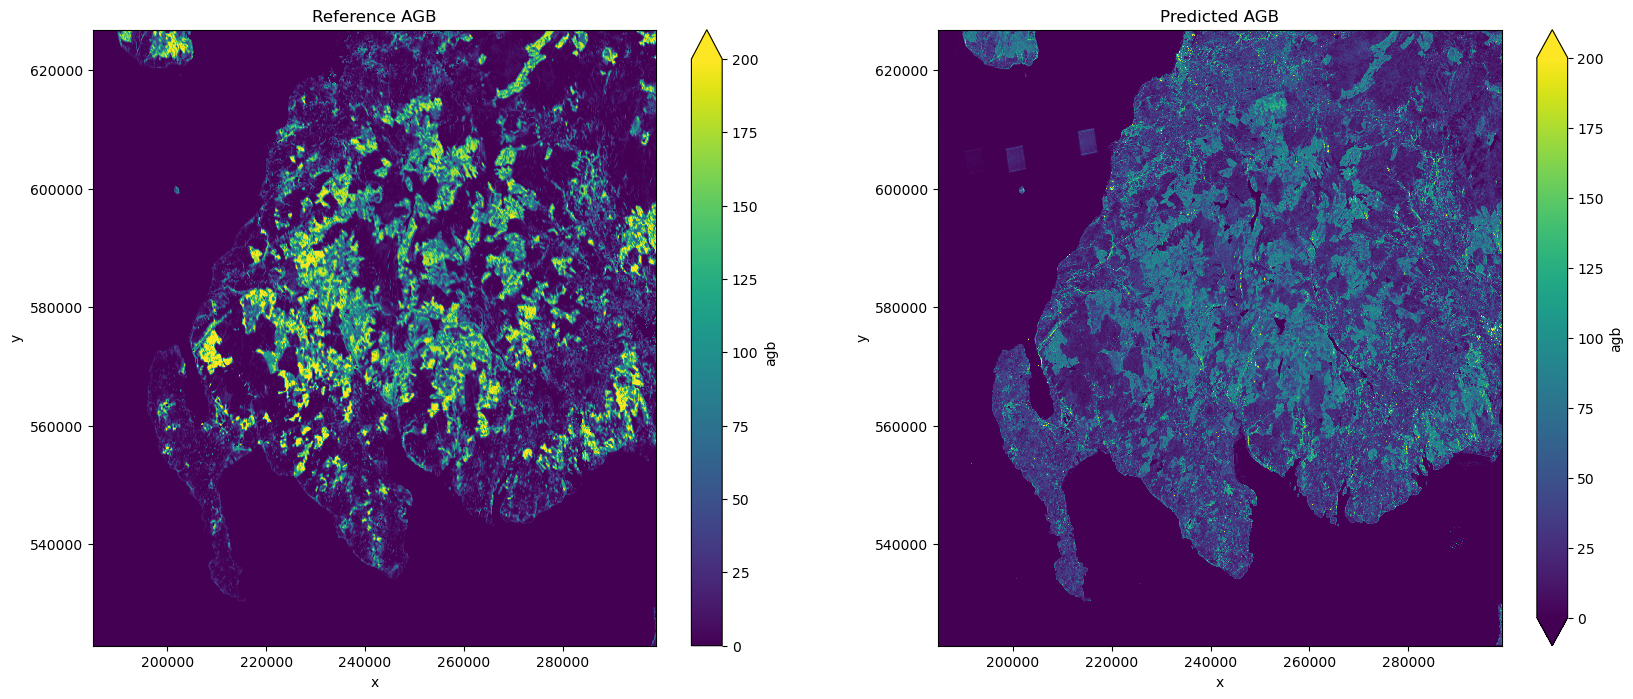

In [36]:
# Create 1x2 subplot grid
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
agb['agb'].plot(ax=ax[0], vmin=0, vmax=200)
ax[0].set_title('Reference AGB')
pred.plot(ax=ax[1], vmin=0, vmax=200)
ax[1].set_title('Predicted AGB');

In [39]:
from sklearn.linear_model import Lasso

In [60]:
clf = Lasso(alpha=0.05, fit_intercept=False)

We set `fit_intercept` to `False` because we have already introduced a column of ones into the matrix $\mathbf{X}$ for this purpose. By default, `scikit-learn` will do this for us.

More advanced algorithms will accept multiple parameters in this step,
refer to the documentation of `scikit-learn` for details.

You can find a list of all estimators here: https://scikit-learn.org/stable/modules/classes.html

## Prepare the data for working with `scikit-learn`

In the real world,
we would normally split the data into training and testing data sets.

The classifier would then be fit to (trained on) the training data and scored/validated on the testing data. This is done to avoid overfitting and give a more realistic assessment of the model performance.

In our case overfitting is unlikely since the number of samples is much larger than the number of model parameters ($N \gg D$). Furthermore, a linear regression is unlikely to adequately model this problem in the first place.

In [61]:
clf.fit(X, y)

Lasso(alpha=0.05, fit_intercept=False)

Extract the weights:

In [62]:
dict(zip(['intercept'] + list(X_flat['variable'].values), clf.coef_))

{'intercept': -13.020515,
 'Sigma0_VH_asc': 666.94904,
 'Sigma0_VH_desc': 0.0,
 'Sigma0_VV_asc': 122.58091,
 'Sigma0_VV_desc': 455.70126}

When we compare the weights to our manually computed $\hat\beta$ above, 
we can see that they are identical except for a small numeric discrepancy.
This discrepancy can likely be attributed to internal approximations
in the `scikit-learn` implementation,
as the library is highly optimised for computational performance.

For example, the `scikit-learn` implementation is unlikely to compute 
the inverse matrix as this is a computationally expensive operation.
Instead, iterative solvers would normally be used.

Predict the AGB using our model:

In [63]:
# Create an empty xarray dataset
# that we can populate with our predictions
pred = y_flat.copy(data=np.zeros_like(y_flat.values))

# Fill in the values corresponding to our mask
pred[mask] = clf.predict(X)

Compute the $R^2$ score:

In [64]:
clf.score(X, y)

0.5009836311455347

Recreate the two-dimensional image:

In [65]:
pred = pred.unstack().transpose('y', 'x')

### Plot the reference AGB vs the predicted AGB

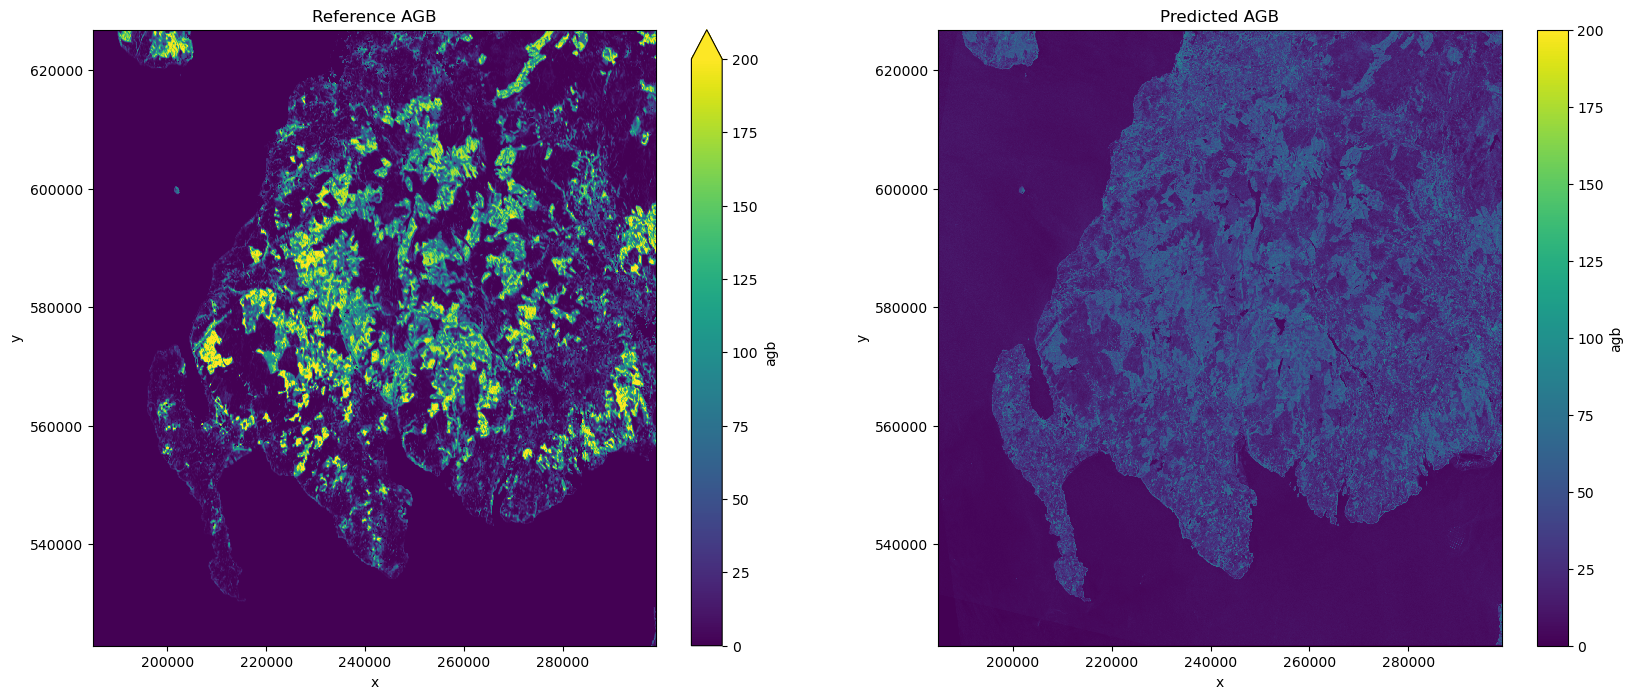

In [53]:
# Create 1x2 subplot grid
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
agb['agb'].plot(ax=ax[0], vmin=0, vmax=200)
ax[0].set_title('Reference AGB')
pred.plot(ax=ax[1], vmin=0, vmax=200)
ax[1].set_title('Predicted AGB');

# Further Exploration: LASSO

Now that you have seen how to perform a linear regression manually and using `scikit-learn`,
repeat this process for a linear regression with Lasso penalty.

Use `scikit-learn`'s built-in Lasso estimator for this: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

Note that the regularisation parameter $\lambda$ is called `alpha` in the `scikit-learn` implementation.

You can also implement a polynomial regression (*hint*: combine `LinearRegression()` with `PolynomialFeatures` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)).

---

# [Optional] Repeating Linear Regression Using `nd`

`nd` is a library that contains a few convenience functions for working with Earth Observation data in `xarray` datasets, such as applying `scikit-learn` estimators to raster data, reprojecting and resampling datasets, applying arbitrary functions across dimensions, and creating easy visualising.

If you work a lot with `xarray` datasets, this could be useful.

Installation: `pip install nd` \
or latest version from Github: `pip install git+https://github.com/jnhansen/nd`

Note that Windows isn't officially supported, but you may still be able to install this.

In [28]:
import nd
import nd.classify

In [29]:
clf = nd.classify.Classifier(LinearRegression())

In [30]:
clf.fit(s1, agb['agb'])

In [31]:
pred = clf.predict(s1).transpose('y', 'x')

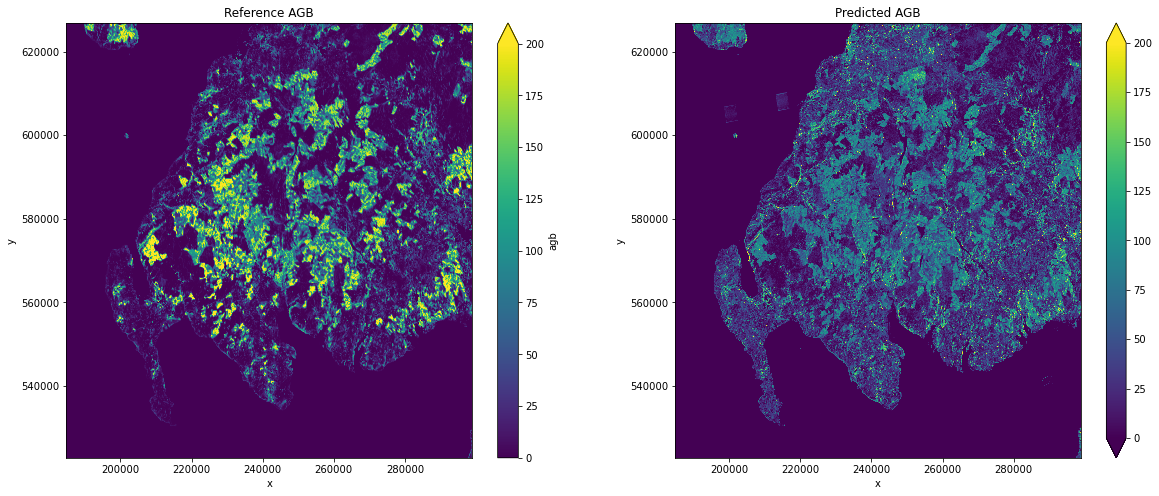

In [32]:
# Create 1x2 subplot grid
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
agb['agb'].plot(ax=ax[0], vmin=0, vmax=200)
ax[0].set_title('Reference AGB')
pred.plot(ax=ax[1], vmin=0, vmax=200)
ax[1].set_title('Predicted AGB');